In [1]:
import os
import sys
import random
import json
import collections
import re
from itertools import combinations

import pandas as pd
import numpy as np
import scipy
import statsmodels
from tqdm import trange, tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from lightgbm import LGBMClassifier

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline


pd.options.display.max_columns = 999

pd.options.display.max_rows = 100

sns.set()
plt.rcParams["figure.figsize"] = (10,7)

In [2]:
%load_ext autoreload
%autoreload 2

In [68]:
from sigmod_src.make_dataset import make_specs_dataset
from sigmod_src.preprocessing import preprocess_specs_dataset
from sigmod_src.pipeline import LGBMPipeline
from sigmod_src.utils import get_additional_labels, make_classes_df

In [5]:
LG_LABELS_PATH = '../data/raw/sigmod_large_labelled_dataset.csv'
SPECS_PATH = '../data/raw/2013_camera_specs/'

# Load labels df

In [6]:
labels_df = pd.read_csv(LG_LABELS_PATH)
labels_df.shape

(297651, 3)

# Load specs df

In [10]:
specs_dataset_src = make_specs_dataset(SPECS_PATH)

In [25]:
specs_df = preprocess_specs_dataset(specs_dataset_src)

Conflict, no matching items found for brand: nikon
Conflict, no matching items found for brand: dgx
Conflict, no matching items found for brand: nikon
Conflict, no matching items found for brand: ion
Conflict, no matching items found for brand: nikon
Conflict, no matching items found for brand: nikon
Conflict, no matching items found for brand: digital
Conflict, no matching items found for brand: olympu
Conflict, no matching items found for brand: nikon
Conflict, no matching items found for brand: nikon
Conflict, no matching items found for brand: panasoniclumix
Conflict, no matching items found for brand: digital
Conflict, no matching items found for brand: ion
Conflict, no matching items found for brand: digital
Conflict, no matching items found for brand: phoenix
Conflict, no matching items found for brand: akai
Conflict, no matching items found for brand: nikon
Conflict, no matching items found for brand: nikon
Conflict, no matching items found for brand: nikon
Conflict, no matchin

/home/boris/study/UT study/ACM Sigmod/sigmod/sigmod_src/preprocessing.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specs_df['brand'] = specs_df['brand'].apply(lambda brand: None if brand in cutoff_brands or not brand else brand)


Dropping 1068 camera bag specs
Dropping 1618 cctv specs
9
Warning, dropped 9 rows containing null page titles


/home/boris/study/UT study/ACM Sigmod/sigmod/sigmod_src/preprocessing.py:230: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('Dropping', specs_df[specs_df.brand.isnull()][specs_df.page_title.str.contains('bag')][specs_df.page_title.str.contains('case')].shape[0], 'camera bag specs')


In [26]:
specs_df.index = specs_df.spec_id

In [27]:
specs_df.head()

,spec_id,page_title,brand,model,all_text,page_title_stem,all_text_stem,site
spec_id,,,,,,,,
www.ebay.com//57656,www.ebay.com//57656,canon powershot elph 110 hs 16 1mp digital,canon,None,canon powershot 110 hs 16 1mp digital canon re...,canon powershot elph 110 hs 16 1mp digit,canon powershot 110 hs 16 1mp digit canon refu...,www.ebay.com
www.ebay.com//60583,www.ebay.com//60583,canon rebel 2000 35mm great case instruction b...,canon,None,canon rebel 2000 35mm great case instruction b...,canon rebel 2000 35mm great case instruct booklet,canon rebel 2000 35mm great case instruct book...,www.ebay.com
www.ebay.com//60440,www.ebay.com//60440,canon eos rebel t3i digital slr 18 55mm 75 300...,canon,t3i,canon eos rebel t3i digital slr 18 55mm 75 300...,canon eo rebel t3i digit slr 18 55mm 75 300mm ...,canon eo rebel t3i digit slr 18 55mm 75 300mm ...,www.ebay.com
www.ebay.com//24139,www.ebay.com//24139,ge c1033 10 1mp digital 3x zoom 2 4 lcd,None,c1033,ge c1033 10 1mp digital 3x zoom 2 4 ge brand-n...,ge c1033 10 1mp digit 3x zoom 2 4 lcd,ge c1033 10 1mp digit 3x zoom 2 4 ge brand-new...,www.ebay.com
www.ebay.com//54903,www.ebay.com//54903,vivitar clip shot digital 1 1mp,vivitar,None,vivitar clip shot digital 1 1mp vivitar brand-...,vivitar clip shot digit 1 1mp,vivitar clip shot digit 1 1mp vivitar brand-ne...,www.ebay.com


In [33]:
sample = specs_df.sample(5)
sample[['page_title', 'page_title_stem', 'brand', 'model']].values

array([['casio exilim ex h30bk 16 1mp digital 4971850494867',
        'casio exilim ex h30bk 16 1mp digit 4971850494867', 'casio',
        None],
       ['mini hd waterproof touch digital children children waterproof touch screen alibaba com',
        'mini hd waterproof touch digit children children waterproof touch screen alibaba com',
        None, None],
       ['canon powershot a310 3 2mp digital parts repair final sale',
        'canon powershot a310 3 2mp digit part repair final sale',
        'canon', 'a310'],
       ['fashion waterproof digital slr vintage bag case nikon canon nikon fashion bag waterproof bag vintage bag alibaba com',
        'fashion waterproof digit slr vintag bag case nikon canon nikon fashion bag waterproof bag vintag bag alibaba com',
        'canon', None],
       ['dahua ip speed dome 20x 1080p ptz sd6a220-hn ip speed dome ir ptz ir ptz alibaba com',
        'dahua ip speed dome 20x 1080p ptz sd6a220-hn ip speed dome ir ptz ir ptz alibaba com',
        

In [34]:
specs_df.brand.value_counts()[:10]

canon        5527
sony         3384
nikon        3362
fujifilm     1517
olympus      1465
panasonic    1358
samsung      1074
kodak         763
pentax        627
casio         222
Name: brand, dtype: int64

In [35]:
specs_df.model.value_counts()[:10]

t3i      203
d3200    188
60d      180
d5200    142
1100d    142
70d      139
d7000    139
d5100    138
d3100    114
d7100    114
Name: model, dtype: int64

# Additional labels

In [ ]:
additional_labels = get_additional_labels(labels_df, specs_df)

In [ ]:
new_dups = additional_labels[additional_labels.label==1]
new_dups.head()

In [ ]:
new_dups.shape

In [ ]:
sample = new_dups.sample(1)

print('Left\n', specs_df.loc[sample.left_spec_id].page_title_stem.values[0])
print('')
print('Right\n', specs_df.loc[sample.right_spec_id].page_title_stem.values[0])

In [ ]:
new_non_dups = additional_labels[additional_labels.label==0]
new_non_dups.shape

In [ ]:
sample = new_non_dups.sample(1)

print('Left\n', specs_df.loc[sample.left_spec_id].page_title_stem.values[0])
print('')
print('Right\n', specs_df.loc[sample.right_spec_id].page_title_stem.values[0])

# Test pipeline

In [40]:
from sigmod_src.pipeline import LGBMPipeline

In [41]:
model = LGBMPipeline(specs_df, labels_df)

In [42]:
model.labels

array([1, 0, 0, ..., 0, 0, 0])

In [46]:
model.precompute()

1264it [00:00, 4978.09it/s]
100%|██████████| 41/41 [01:27<00:00,  2.14s/it]


In [47]:
x = model.make_X([0, 2], [1, 3])
x.shape

(2, 21)

In [25]:
train_left_spec_idx = model.specs_id_to_idx[labels_df['left_spec_id']]
train_right_spec_idx = model.specs_id_to_idx[labels_df['right_spec_id']]

train_X = model.make_X(train_left_spec_idx, train_right_spec_idx)

assert train_X.shape[0] == labels_df.shape[0]

In [48]:
model.train(precompute=False)

Precomputing
Making features
Making features for additional_labels
Fitting model


In [51]:
pred_train = model.clf.predict(model.train_X)

print('Train F1', f1_score(labels_df.label, pred_train))
print(classification_report(labels_df.label, pred_train))

Train F1 0.9903225080458219
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    253612
           1       0.98      1.00      0.99     44039

    accuracy                           1.00    297651
   macro avg       0.99      1.00      0.99    297651
weighted avg       1.00      1.00      1.00    297651



Sanity check passed

# Feature importance

In [37]:
import shap

In [38]:
explainer = shap.TreeExplainer(model.clf)

In [40]:
shap_values = explainer.shap_values(model.train_X)

In [42]:
feature_names = model.feature_names

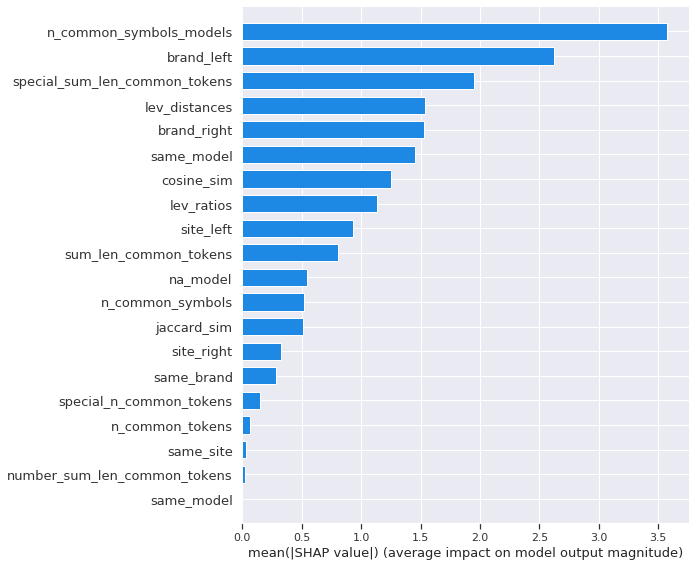

In [43]:
shap.summary_plot(shap_values, model.train_X, plot_type="bar", feature_names=feature_names)

# Submit

In [52]:
model.make_submission()

100%|██████████| 62/62 [17:07<00:00, 16.57s/it] 


In [53]:
submit_df = pd.read_csv('../data/submit/submit.csv')
submit_df.shape

(1059721, 2)

In [54]:
specs_df.index = specs_df.spec_id

In [64]:
row = submit_df.sample(1)

print('Left\n', specs_df.loc[row.left_spec_id].page_title.values[0])
print('')
print('Right\n', specs_df.loc[row.right_spec_id].page_title.values[0])

Left
 700tvl effio-e digital cctv 42 pieces ir-led security waterproof bullet digital waterproof cctv security waterproof bullet waterproof bullet alibaba com

Right
 high quality array led ir digital color ccd 700tvl cctv sony color ccd chip ir digital color ccd digital color cctv cctv 700tvl alibaba com


# CV

In [65]:
def get_split(classes_df, labels_df, test_classes=5):
    classes = classes_df.class_.unique()
    test_classes = np.random.choice(classes, test_classes)
    
    test_spec_ids = classes_df[classes_df.class_.isin(test_classes)].spec_id
    
    test_label_mask = labels_df.left_spec_id.isin(test_spec_ids) | labels_df.right_spec_id.isin(test_spec_ids)
    
    test_idx = np.array(labels_df[test_label_mask].index)
    train_idx = np.array(labels_df[~test_label_mask].index)
    
    return train_idx, test_idx

def evaluate_submit(submit_df, test_labels_df):
    submit_df = submit_df.copy()
    submit_df['label'] = 1
    
    merged = test_labels_df.merge(submit_df, on=['left_spec_id', 'right_spec_id'], how='left', suffixes = ('_true', '_pred'))
    merged['label_pred'] = merged['label_pred'].fillna(0)
    
    tp = merged[(merged.label_true == 1) & (merged.label_pred == 1)]
    tn = merged[(merged.label_true == 0) & (merged.label_pred == 0)]
    
    fp = merged[(merged.label_true == 0) & (merged.label_pred == 1)]
    fn = merged[(merged.label_true == 1) & (merged.label_pred == 0)]
    
    precision = tp.shape[0]/(tp.shape[0]+fp.shape[0])
    recall = tp.shape[0]/(tp.shape[0]+fn.shape[0])
    
    f1 = 2 * (precision * recall)/(precision+recall)
    
    return f1, tp, tn, fp, fn

def cross_validate_pipeline(pipeline_class, specs_df, labels_df, n_folds=5, test_classes=5):
    # Obtain triangles from label and number them
    classes_df = make_classes_df(labels_df)
    folds = []
    submit_fpaths = []
    scores = []
    for i_fold in tqdm(range(n_folds)):
        print('Fold', i_fold)
        labels_train_idx, labels_test_idx = get_split(classes_df, labels_df, test_classes=test_classes)
        folds.append( (labels_train_idx, labels_test_idx) )
        
        train_labels = labels_df.iloc[labels_train_idx].copy()
        test_labels = labels_df.iloc[labels_test_idx].copy()
        
        submit_fpath = f'../data/interim/cv_submit_fold{i_fold}.csv'
        submit_fpaths.append(submit_fpath)
        
        model = pipeline_class(specs_df, train_labels, submit_fpath=submit_fpath)
        print('training model')
        model.train()
        
        print('generating submit')
        model.make_submission()
        
        print('evaluating submit')
        f1score, _, _, _, _ = evaluate_submit(pd.read_csv(model.submit_fpath), test_labels)
        scores.append(f1score)
        print('Score', f1score)
    return folds, submit_fpaths, scores

In [ ]:
# np.random.seed(42)
np.random.seed(None)
folds, submit_fpaths, scores = cross_validate_pipeline(LGBMPipeline, specs_df, labels_df, n_folds=3)

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

Fold 0
training model
Precomputing




0it [00:00, ?it/s]

91it [00:00, 873.75it/s]

287it [00:00, 1047.79it/s]

559it [00:00, 1284.68it/s]

960it [00:00, 1613.46it/s]

1264it [00:00, 2607.95it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

 10%|▉         | 4/41 [00:11<01:43,  2.79s/it]

 12%|█▏        | 5/41 [00:11<01:15,  2.11s/it]

 34%|███▍      | 14/41 [00:20<00:48,  1.78s/it]

 46%|████▋     | 19/41 [00:27<00:36,  1.65s/it]

 59%|█████▊    | 24/41 [00:37<00:29,  1.76s/it]

 61%|██████    | 25/41 [00:44<00:51,  3.25s/it]

 63%|██████▎   | 26/41 [00:50<01:01,  4.13s/it]

 66%|██████▌   | 27/41 [00:51<00:45,  3.24s/it]

 71%|███████   | 29/41 [00:51<00:27,  2.29s/it]

 78%|███████▊  | 32/41 [00:55<00:17,  1.99s/it]

 80%|████████  | 33/41 [00:55<00:11,  1.43s/it]

 93%|█████████▎| 38/41 [01:43<00:11,  3.83s/it]

 98%|█████████▊| 40/41 [01:43<00:02,  2.72s/it]

100%|██████████| 41/41 [01:43<00:00,  2.52s/it]

Making features
Making features for additional_labels
Fitting model




  0%|          | 0/62 [00:00<?, ?it/s]

generating submit




  2%|▏         | 1/62 [00:01<01:04,  1.07s/it]

  8%|▊         | 5/62 [08:12<35:44, 37.62s/it]

 10%|▉         | 6/62 [08:14<25:00, 26.80s/it]

 15%|█▍        | 9/62 [08:14<16:35, 18.78s/it]

 23%|██▎       | 14/62 [08:14<10:31, 13.15s/it]

 23%|██▎       | 14/62 [08:30<10:31, 13.15s/it]

 26%|██▌       | 16/62 [09:18<14:23, 18.77s/it]

 31%|███       | 19/62 [09:20<09:35, 13.37s/it]

 39%|███▊      | 24/62 [09:30<06:17,  9.92s/it]

 42%|████▏     | 26/62 [09:30<04:12,  7.02s/it]

 53%|█████▎    | 33/62 [09:30<02:22,  4.92s/it]

 53%|█████▎    | 33/62 [09:42<02:22,  4.92s/it]

 55%|█████▍    | 34/62 [12:28<26:29, 56.76s/it]

 56%|█████▋    | 35/62 [13:01<22:17, 49.55s/it]

 60%|█████▉    | 37/62 [13:31<16:21, 39.26s/it]

 61%|██████▏   | 38/62 [13:37<11:42, 29.26s/it]

 65%|██████▍   | 40/62 [13:37<07:31, 20.52s/it]

 68%|██████▊   | 42/62 [13:37<04:47, 14.38s/it]

 71%|███████   | 44/62 [13:56<03:52, 12.90s/it]

 79%|███████▉  | 49/62 [13:56<01:57,  9.04s/it]

 82%|████████▏ | 51/62

evaluating submit
Score 0.7666666666666667
Fold 1
training model
Precomputing




0it [00:00, ?it/s]

470it [00:00, 4683.89it/s]

1119it [00:00, 5109.77it/s]

1264it [00:00, 5634.71it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

 10%|▉         | 4/41 [00:09<01:30,  2.44s/it]

 12%|█▏        | 5/41 [00:10<01:06,  1.85s/it]

 34%|███▍      | 14/41 [00:18<00:42,  1.56s/it]

 46%|████▋     | 19/41 [00:24<00:32,  1.48s/it]

 59%|█████▊    | 24/41 [00:35<00:28,  1.65s/it]

 61%|██████    | 25/41 [00:42<00:52,  3.28s/it]

 63%|██████▎   | 26/41 [00:49<01:06,  4.42s/it]

 66%|██████▌   | 27/41 [00:50<00:47,  3.38s/it]

 71%|███████   | 29/41 [00:50<00:28,  2.39s/it]

 78%|███████▊  | 32/41 [00:53<00:18,  2.03s/it]

 93%|█████████▎| 38/41 [01:29<00:09,  3.20s/it]

 98%|█████████▊| 40/41 [01:29<00:02,  2.26s/it]

100%|██████████| 41/41 [01:29<00:00,  2.19s/it]

Making features
Making features for additional_labels
Fitting model




  0%|          | 0/62 [00:00<?, ?it/s]

generating submit




  2%|▏         | 1/62 [00:00<00:49,  1.23it/s]

  8%|▊         | 5/62 [11:23<49:10, 51.77s/it]

 10%|▉         | 6/62 [11:24<34:02, 36.47s/it]

 26%|██▌       | 16/62 [12:03<20:29, 26.72s/it]

 31%|███       | 19/62 [12:05<13:29, 18.82s/it]

 39%|███▊      | 24/62 [12:13<08:39, 13.66s/it]

 42%|████▏     | 26/62 [12:13<05:46,  9.63s/it]

 55%|█████▍    | 34/62 [14:35<05:38, 12.08s/it]

 56%|█████▋    | 35/62 [15:19<09:41, 21.53s/it]

 60%|█████▉    | 37/62 [15:56<08:34, 20.56s/it]

 61%|██████▏   | 38/62 [16:03<06:37, 16.54s/it]

 65%|██████▍   | 40/62 [16:03<04:15, 11.62s/it]

 68%|██████▊   | 42/62 [16:03<02:43,  8.16s/it]

 71%|███████   | 44/62 [16:27<02:48,  9.35s/it]

 79%|███████▉  | 49/62 [16:28<01:25,  6.56s/it]

 82%|████████▏ | 51/62 [20:19<07:12, 39.36s/it]

 85%|████████▌ | 53/62 [20:20<04:08, 27.57s/it]

 95%|█████████▌| 59/62 [20:20<00:57, 19.33s/it]

100%|██████████| 62/62 [20:20<00:00, 19.69s/it]

evaluating submit
Score 0.57703081232493
Fold 2




0it [00:00, ?it/s]

training model
Precomputing




352it [00:00, 3515.30it/s]

705it [00:00, 3518.78it/s]

1147it [00:00, 3746.52it/s]

1264it [00:00, 3841.01it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

 10%|▉         | 4/41 [00:11<01:49,  2.95s/it]

 12%|█▏        | 5/41 [00:12<01:19,  2.22s/it]

 34%|███▍      | 14/41 [00:20<00:49,  1.83s/it]

 46%|████▋     | 19/41 [00:26<00:36,  1.65s/it]

 59%|█████▊    | 24/41 [00:36<00:29,  1.72s/it]

 61%|██████    | 25/41 [00:45<01:03,  3.97s/it]

 63%|██████▎   | 26/41 [00:52<01:12,  4.83s/it]

 66%|██████▌   | 27/41 [00:53<00:51,  3.66s/it]

 71%|███████   | 29/41 [00:53<00:31,  2.59s/it]

 78%|███████▊  | 32/41 [00:57<00:19,  2.17s/it]

 80%|████████  | 33/41 [00:57<00:12,  1.56s/it]

 93%|█████████▎| 38/41 [01:31<00:09,  3.13s/it]

 98%|█████████▊| 40/41 [01:31<00:02,  2.21s/it]

100%|██████████| 41/41 [01:31<00:00,  2.23s/it]

Making features
Making features for additional_labels
Fitting model




  0%|          | 0/62 [00:00<?, ?it/s]

generating submit




  2%|▏         | 1/62 [00:00<00:51,  1.18it/s]

In [ ]:
scores

In [ ]:
np.mean(scores)

## Test evaluation scheme

In [ ]:

    
    
test_labels_df = labels_df.iloc[folds[0][1]]
submit_df = pd.read_csv(submit_fpaths[0])

score, tp, tn, fp, fn = evaluate_submit(submit_df, test_labels_df)
score

Test one true positive

In [ ]:
tp.head()

In [ ]:
test_labels_df[test_labels_df.label == 1][test_labels_df.left_spec_id == 'www.ebay.com//24206']

In [ ]:
submit_df[(submit_df.left_spec_id == 'www.ebay.com//24206') & (submit_df.right_spec_id == 'www.priceme.co.nz//54')]

Pass

Check one tn

In [ ]:
tn.head()

In [ ]:
test_labels_df[test_labels_df.label == 0][test_labels_df.left_spec_id == 'www.ebay.com//42074'][test_labels_df.right_spec_id == 'www.ebay.com//47107']

In [ ]:
submit_df[submit_df.left_spec_id == 'www.ebay.com//42074'][submit_df.right_spec_id == 'www.ebay.com//47107']

Pass

Check one fp

In [ ]:
fp.head()

In [ ]:
test_labels_df[test_labels_df.label == 0][test_labels_df.left_spec_id == 'www.ebay.com//42074'][test_labels_df.right_spec_id == 'www.ebay.com//54040']

In [ ]:
submit_df[submit_df.left_spec_id == 'www.ebay.com//42074'][submit_df.right_spec_id == 'www.ebay.com//54040']

Pass

Check one fn

In [ ]:
fn.head()

In [ ]:
test_labels_df[test_labels_df.label == 1][test_labels_df.left_spec_id == 'www.ebay.com//54040'][test_labels_df.right_spec_id == 'www.ebay.com//54457']

In [ ]:
submit_df[submit_df.left_spec_id == 'www.ebay.com//54040'][submit_df.right_spec_id == 'www.ebay.com//54457']

pass